Normalize images (without augmentation) for kernel method

In [1]:
import sys
sys.path.insert(0,'..')

import os
import glob
from tqdm.notebook import tqdm
import cv2 
import numpy as np
import pandas as pd

from image_processing.utils import show
from image_processing.preprocessing import (
    remove_padding,
    pad_to_square
)

from image_processing.shape_normalization.moment import normalize as moment_normalization
from image_processing.shape_normalization.bimoment import normalize as bimoment_normalization
from image_processing.shape_normalization.p2d_bimoment import normalize as p2d_bimoment_normalization

## Demo

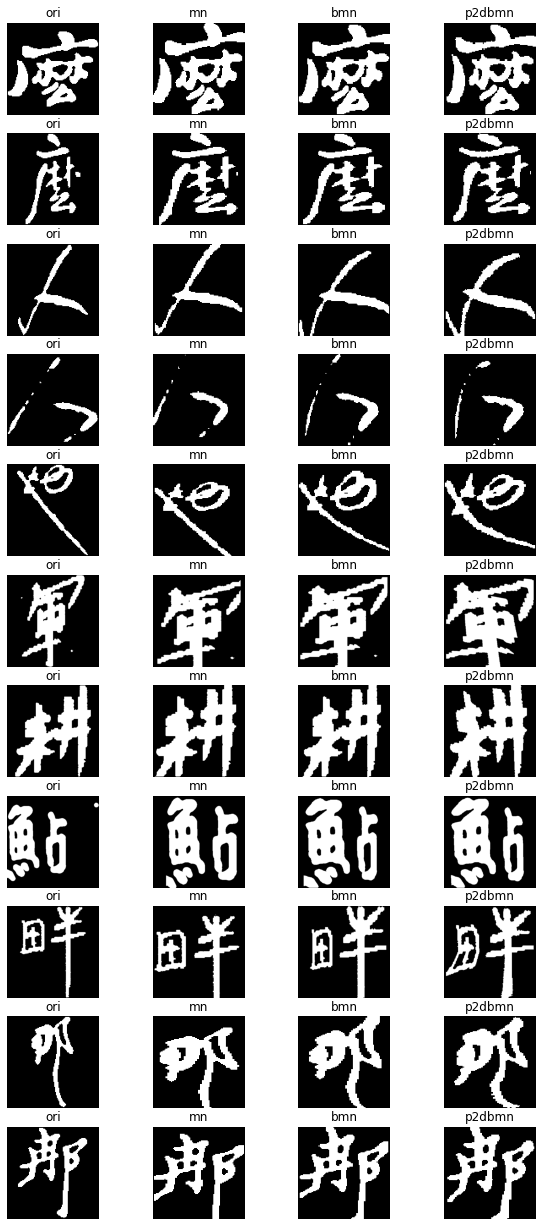

In [2]:
SN_DATA_PATH = './../../data/sample_data/shape_normalization/*.png'

imgs = []
titles = []
fnames = glob.glob(SN_DATA_PATH)

for fname in fnames:
    
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = (img_init > 0) * 255
    img_init = remove_padding(img_init)
    
    img_mn = moment_normalization(img_init, alpha=4)
    img_bmn = bimoment_normalization(img_init, beta=2)
    img_p2dbmn = p2d_bimoment_normalization(img_init, beta=2, w0=0.5)
    
    imgs += [img_init, img_mn, img_bmn, img_p2dbmn]
    titles += ['ori', 'mn', 'bmn', 'p2dbmn']

imgs = [pad_to_square(img, max(img.shape)) for img in imgs]
show(imgs, col=4, titles=titles)

___

In [3]:
DATA_DIR = '/Users/kx/Docs/github/git_cccr_sl/chinese-calligraphy-recognition-sl/data/cccr'
N, M = 128, 128

## Load Data

In [4]:
def read_data(data_dir):
    images = np.zeros((len(glob.glob(data_dir + '/*/*/*.png')), N, M))
    fnames = []

    i = 0
    for folder in glob.glob(data_dir + '/*/*/'):
        tmp = folder.split('/')
        char = tmp[-3]
        variant = tmp[-2]
        for file in glob.glob(data_dir + '/{}/{}/*.png'.format(char, variant)):
            img = cv2.resize(cv2.imread(file), (M, N))[:, :, 0]
            images[i, :, :] = img
            fnames.append('/'.join(file.split('/')[-3:]))
            i += 1
            
    return images, fnames

imgs_train, fnames_train = read_data(os.path.join(DATA_DIR, 'train'))
imgs_valid, fnames_valid = read_data(os.path.join(DATA_DIR, 'validation'))
imgs_test, fnames_test = read_data(os.path.join(DATA_DIR, 'test'))

## Processing

In [5]:
def preprocess_image_pdfe(img, N):
    
    img = remove_padding(img)
    img_norm = p2d_bimoment_normalization(img, beta=2, w0=0.5)
    img_norm = pad_to_square(img_norm, max(img_norm.shape))
    img_norm = cv2.resize(img_norm, (N, N))
    img_norm = (img_norm > img_norm.max() / 2 - (img_norm.max()/ 100)).astype('int')
    return img_norm

def preprocess_imgs(imgs):
    imgs_norm = np.zeros((imgs.shape[0], N, M))
    for i in tqdm(range(imgs.shape[0])):
        imgs_norm[i] = preprocess_image_pdfe(imgs[i], N)
    return imgs_norm

imgs_norm_train = preprocess_imgs(imgs_train)
imgs_norm_valid = preprocess_imgs(imgs_valid)
imgs_norm_test = preprocess_imgs(imgs_test)

  0%|          | 0/6035 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Write Data

In [6]:
chars = [(x[-4], x[-2]) for x in glob.glob(DATA_DIR + '/train/*/*/')]

In [7]:
def write_data(data, fnames, data_dir):
    os.mkdir(data_dir)
    for char, variant in chars:
        char_dir = os.path.join(data_dir, char)
        if not os.path.isdir(char_dir):
            os.mkdir(char_dir)
        var_dir = os.path.join(char_dir, variant)
        if not os.path.isdir(var_dir):
            os.mkdir(var_dir)

    for i in range(len(data)):
        cv2.imwrite(os.path.join(data_dir, fnames[i]), data[i] * 255)

In [8]:
write_data(imgs_norm_train, fnames_train, '../../data/cccr_norm/train')
write_data(imgs_norm_valid, fnames_valid, '../../data/cccr_norm/validation')
write_data(imgs_norm_test, fnames_test, '../../data/cccr_norm/test')